In [1]:
import os
import glob
import numpy as np
import torch.nn as nn
import torch
import cv2
from PIL import Image
from skimage import exposure
import matplotlib.pyplot as plt
from utils import *
import lpips




In [2]:
R_path=glob.glob("data/processed/R/*.jpg")
V_path=glob.glob("data/processed/V/*.jpg")


# histogram equalization

In [20]:
for path in R_path:
    im=cv2.imread(path,cv2.COLOR_RGB2GRAY)
    im=Histogram_equalization(im[:,:,0])
    cv2.imwrite(os.path.join("./generated_images/Histogram_equalization",path[-12:]),im)
    
for path in V_path:
    im=cv2.imread(path,cv2.COLOR_RGB2GRAY)
    im=Histogram_equalization(im[:,:,0])
    cv2.imwrite(os.path.join("./generated_images/Histogram_equalization",path[-12:]),im)
    

'R/R02085.jpg'

# histogram matching

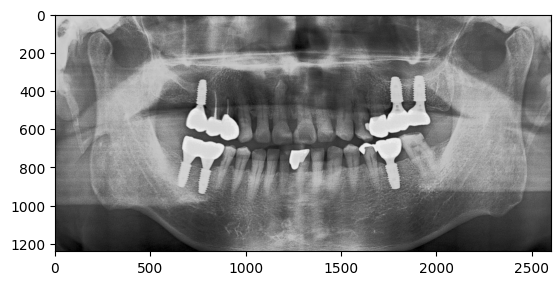

In [3]:
#im=Image.open(R_path[0]).convert("L")
im=cv2.imread(R_path[0],cv2.IMREAD_GRAYSCALE)
im2=cv2.imread(V_path[0],cv2.IMREAD_GRAYSCALE)
plt.imshow(histogram_matching(im,im2),cmap='gray')

(1240, 2600)

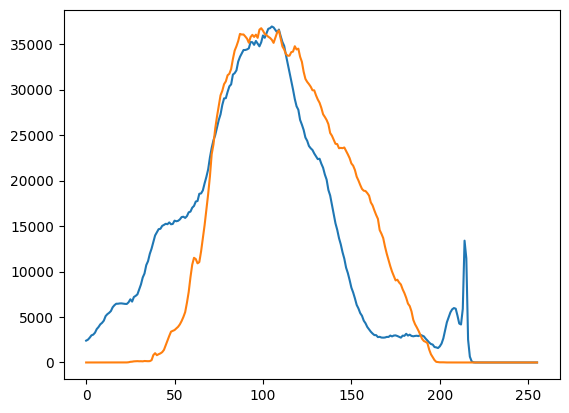

In [14]:
plt.plot(get_histogram(im))
plt.plot(get_histogram(im2))
im.shape

In [32]:
#plt.plot(get_histogram(histogram_matching(im,im2)))
histogram_matching(im,im2).astype('int'),im.shape,get_histogram(im),im

(array([[174, 174, 174, ..., 173, 173, 173],
        [173, 174, 174, ..., 172, 172, 172],
        [173, 174, 174, ..., 172, 172, 171],
        ...,
        [ 62,  62,  63, ...,  50,  51,  51],
        [ 65,  64,  64, ...,  49,  49,  50],
        [ 67,  66,  64, ...,  48,  48,  49]]),
 (1240, 2600),
 array([ 2401,  2505,  2720,  2980,  3060,  3274,  3674,  3896,  4191,
         4357,  4598,  5095,  5312,  5458,  5654,  6068,  6295,  6456,
         6459,  6491,  6496,  6469,  6440,  6433,  6619,  6945,  6692,
         7196,  7322,  7489,  8042,  8578,  9343,  9781, 10704, 11137,
        11940, 12515, 13226, 13963, 14308, 14658, 14693, 15015, 15123,
        15247, 15202, 15398, 15194, 15230, 15590, 15523, 15573, 15726,
        15985, 16023, 15891, 16089, 16508, 16584, 17016, 17212, 17694,
        17753, 18546, 18582, 18918, 19698, 20403, 21225, 22541, 23589,
        24430, 24999, 25844, 26657, 27273, 28311, 29029, 29056, 29751,
        30356, 30572, 31650, 31807, 32113, 33079, 33601, 3398

In [45]:
a=histogram_matching(im,im2).astype('int')
a#get_histogram(a)

array([[174, 174, 174, ..., 173, 173, 173],
       [173, 174, 174, ..., 172, 172, 172],
       [173, 174, 174, ..., 172, 172, 171],
       ...,
       [ 62,  62,  63, ...,  50,  51,  51],
       [ 65,  64,  64, ...,  49,  49,  50],
       [ 67,  66,  64, ...,  48,  48,  49]])

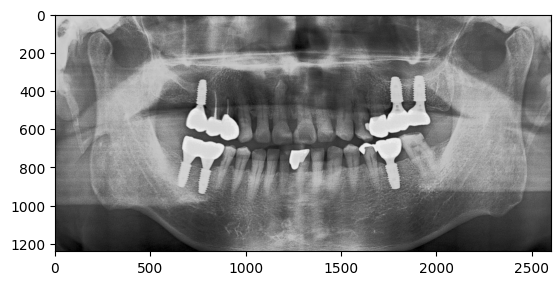

In [22]:
plt.imshow(histogram_matching(im,im2),cmap="gray")

## Histogram matching Mean

In [26]:
hist=np.array([0]*256)

for path in V_path:
    im=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    hist+=get_histogram(im)

hist=hist/len(V_path)
    

In [25]:
im=cv2.imread(V_path[0],cv2.IMREAD_GRAYSCALE)
im_hist=get_histogram(im).shape
hist=np.array([0]*256)
hist.shape

(256,)

In [6]:
hists=[]
im_origin=cv2.imread(V_path[0],cv2.IMREAD_GRAYSCALE)
hist_origin=cv2.calcHist([im_origin],[0],None,[256],[0,256]).astype('int32')

def cos_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
     
for i,path in enumerate(R_path[:500]):
    hist=cv2.calcHist([cv2.imread(path,cv2.IMREAD_GRAYSCALE)],[0],None,[256],[0,256]).astype('int32')
    hists.append(hist.squeeze())
ret=[]
for i,histogram in enumerate(hists):
    ret.append(cos_sim(hists[0],histogram))

print(ret)

KeyboardInterrupt: 

# LPIPS Histogram matching

In [ ]:
from pathlib import Path
from itertools import chain
from torch.utils import data
from torchvision import transforms


def listdir(dname):
    # 해당 경로 하위의 모든 image파일 경로 
    fnames = list(chain(*[list(Path(dname).rglob('*.' + ext))
                          for ext in ['png', 'jpg', 'jpeg', 'JPG']]))
    return fnames

class DefaultDataset(data.Dataset):
    def __init__(self, root, resize=256):
        self.samples=listdir(root)
        self.targets = None
        self.resize=resize
        if self.resize:
            self.transform=transforms.Compose([
                transforms.Resize([self.resize,self.resize]),
                transforms.ToTensor(),
                ])

    def __getitem__(self, index):
        
        fname = self.samples[index]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img,index
    
    def __len__(self):

        return len(self.samples)

def get_train_loader(root,target_root,batchsize=16,num_workers=4,shuffle=False):
    
    dataset=DefaultDataset(root)
    target_dataset=DefaultDataset(target_root)

    loader=data.DataLoader(dataset=dataset,
                           batch_size=1,
                           num_workers=num_workers,
                           shuffle=shuffle
                          )
    target_loader=data.DataLoader(dataset=target_dataset,
                                  batch_size=batchsize,
                                  num_workers=num_workers,
                                  shuffle=shuffle
                                  )
    
    return loader,target_loader

loader,target_loader=get_train_loader('./data/processed/R','./data/processed/V/')
loss_fn_alex=lpips.LPIPS(net='vgg')
GPU_NUM = 5
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

loss_fn_alex.cuda()
a=0
print(len(loader))
loader_path=list(map(lambda x:os.path.basename(x),np.array(loader.dataset.samples)))
target_path=list(map(lambda x:os.path.basename(x),np.array(target_loader.dataset.samples)))
for img,index in loader:
    ds=100,0
    img_path=loader_path[index]
    
    for target in target_loader:
        d=loss_fn_alex(img.cuda(),target[0].cuda()).squeeze()
        for i in range(len(d)):
            if d[i]<=ds[0]:
                ds=d[i],target_path[target[1][i]]
    matched=histogram_matching(cv2.imread(os.path.join('./data/processed/R',img_path),cv2.IMREAD_GRAYSCALE),
                               cv2.imread(os.path.join('./data/processed/V',ds[1]),cv2.IMREAD_GRAYSCALE))

    
    
    cv2.imwrite(os.path.join("./generated_images/LPIPS_Histogram_matching",img_path),matched)



# SSIM Histogram matching

In [59]:
from pathlib import Path
from itertools import chain
from torch.utils import data
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
import cv2


for im_path in R_path:
    a=0
    im=cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)
    ds=1,0
    for target_path in V_path:
        a+=1
        if a%200==0:
            print(a)
        target_im=cv2.resize(cv2.imread(target_path,cv2.IMREAD_GRAYSCALE),(256,256))
        d=structural_similarity(cv2.resize(im,(256,256)),target_im)
        
        if ds[0]>=d:
            ds=d,target_path
        
    matched=histogram_matching(im,cv2.imread(ds[1],cv2.IMREAD_GRAYSCALE))
    cv2.imwrite(os.path.join("./generated_images/SSIM_Histogram_matching",im_path[-10:]),matched)



200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
200
400
600
800
1000
1200
14

In [27]:
list(map(lambda x:os.path.basename(x),np.array(loader.dataset.samples)))[1]

'R00365.jpg'

In [15]:
for i in range(len(d)):
    if d[i]<=ds[0]:
        ds=d[i],target_path[target[1][i]]

d,ds

(tensor([0.4867, 0.4848, 0.5269, 0.4824, 0.4975, 0.4495, 0.4346, 0.4404, 0.4430,
         0.4610, 0.4634, 0.4868, 0.4847, 0.4618, 0.4589, 0.4859],
        device='cuda:5', grad_fn=<SqueezeBackward0>),
 (tensor(0.4346, device='cuda:5', grad_fn=<SelectBackward0>), 'V00546.jpg'))

In [21]:
from skimage import exposure
import matplotlib.pyplot as plt
from torchvision import transforms


src=cv2.resize(cv2.imread(R_path[0]),(256,256))
src=np.array([src,src])
src=np.transpose(src,(0,3,1,2))
ref=cv2.resize(cv2.imread(V_path[5]),(256,256))
ref=np.array([ref,ref])
ref=np.transpose(ref,(0,3,1,2))

#mathced=exposure.match_histograms(src,ref)

In [12]:
from utils import *

In [24]:
import lpips
loss_fn_alex=lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/poong/yes/envs/jaepoong/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [25]:
d=loss_fn_alex(torch.tensor(src),torch.tensor(ref))

In [30]:
d.squeeze()

tensor([0.2093, 0.2093], grad_fn=<SqueezeBackward0>)

In [5]:

matched=histogram_matching(cv2.imread(R_path[0],cv2.IMREAD_GRAYSCALE),cv2.imread(R_path[0],cv2.IMREAD_GRAYSCALE))

In [39]:
np.array(torch.tensor(src)[0]).transpose((1,2,0)).shape,cv2.resize(cv2.imread(R_path[0]),(256,256)).shape


((256, 256, 3), (256, 256, 3))

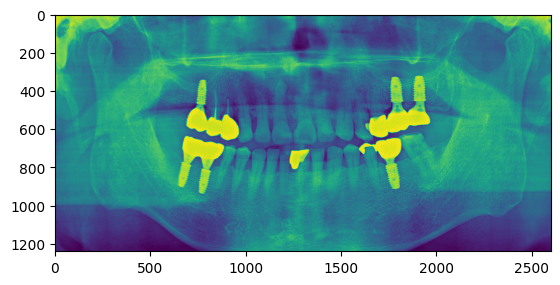

In [6]:
plt.imshow(matched)

In [9]:
torch.tensor(R_path[0])

TypeError: new(): invalid data type 'str'

In [10]:
R_path[0]

'data/processed/R/R02085.jpg'

Preparing DataLoader for the evaluation phase...


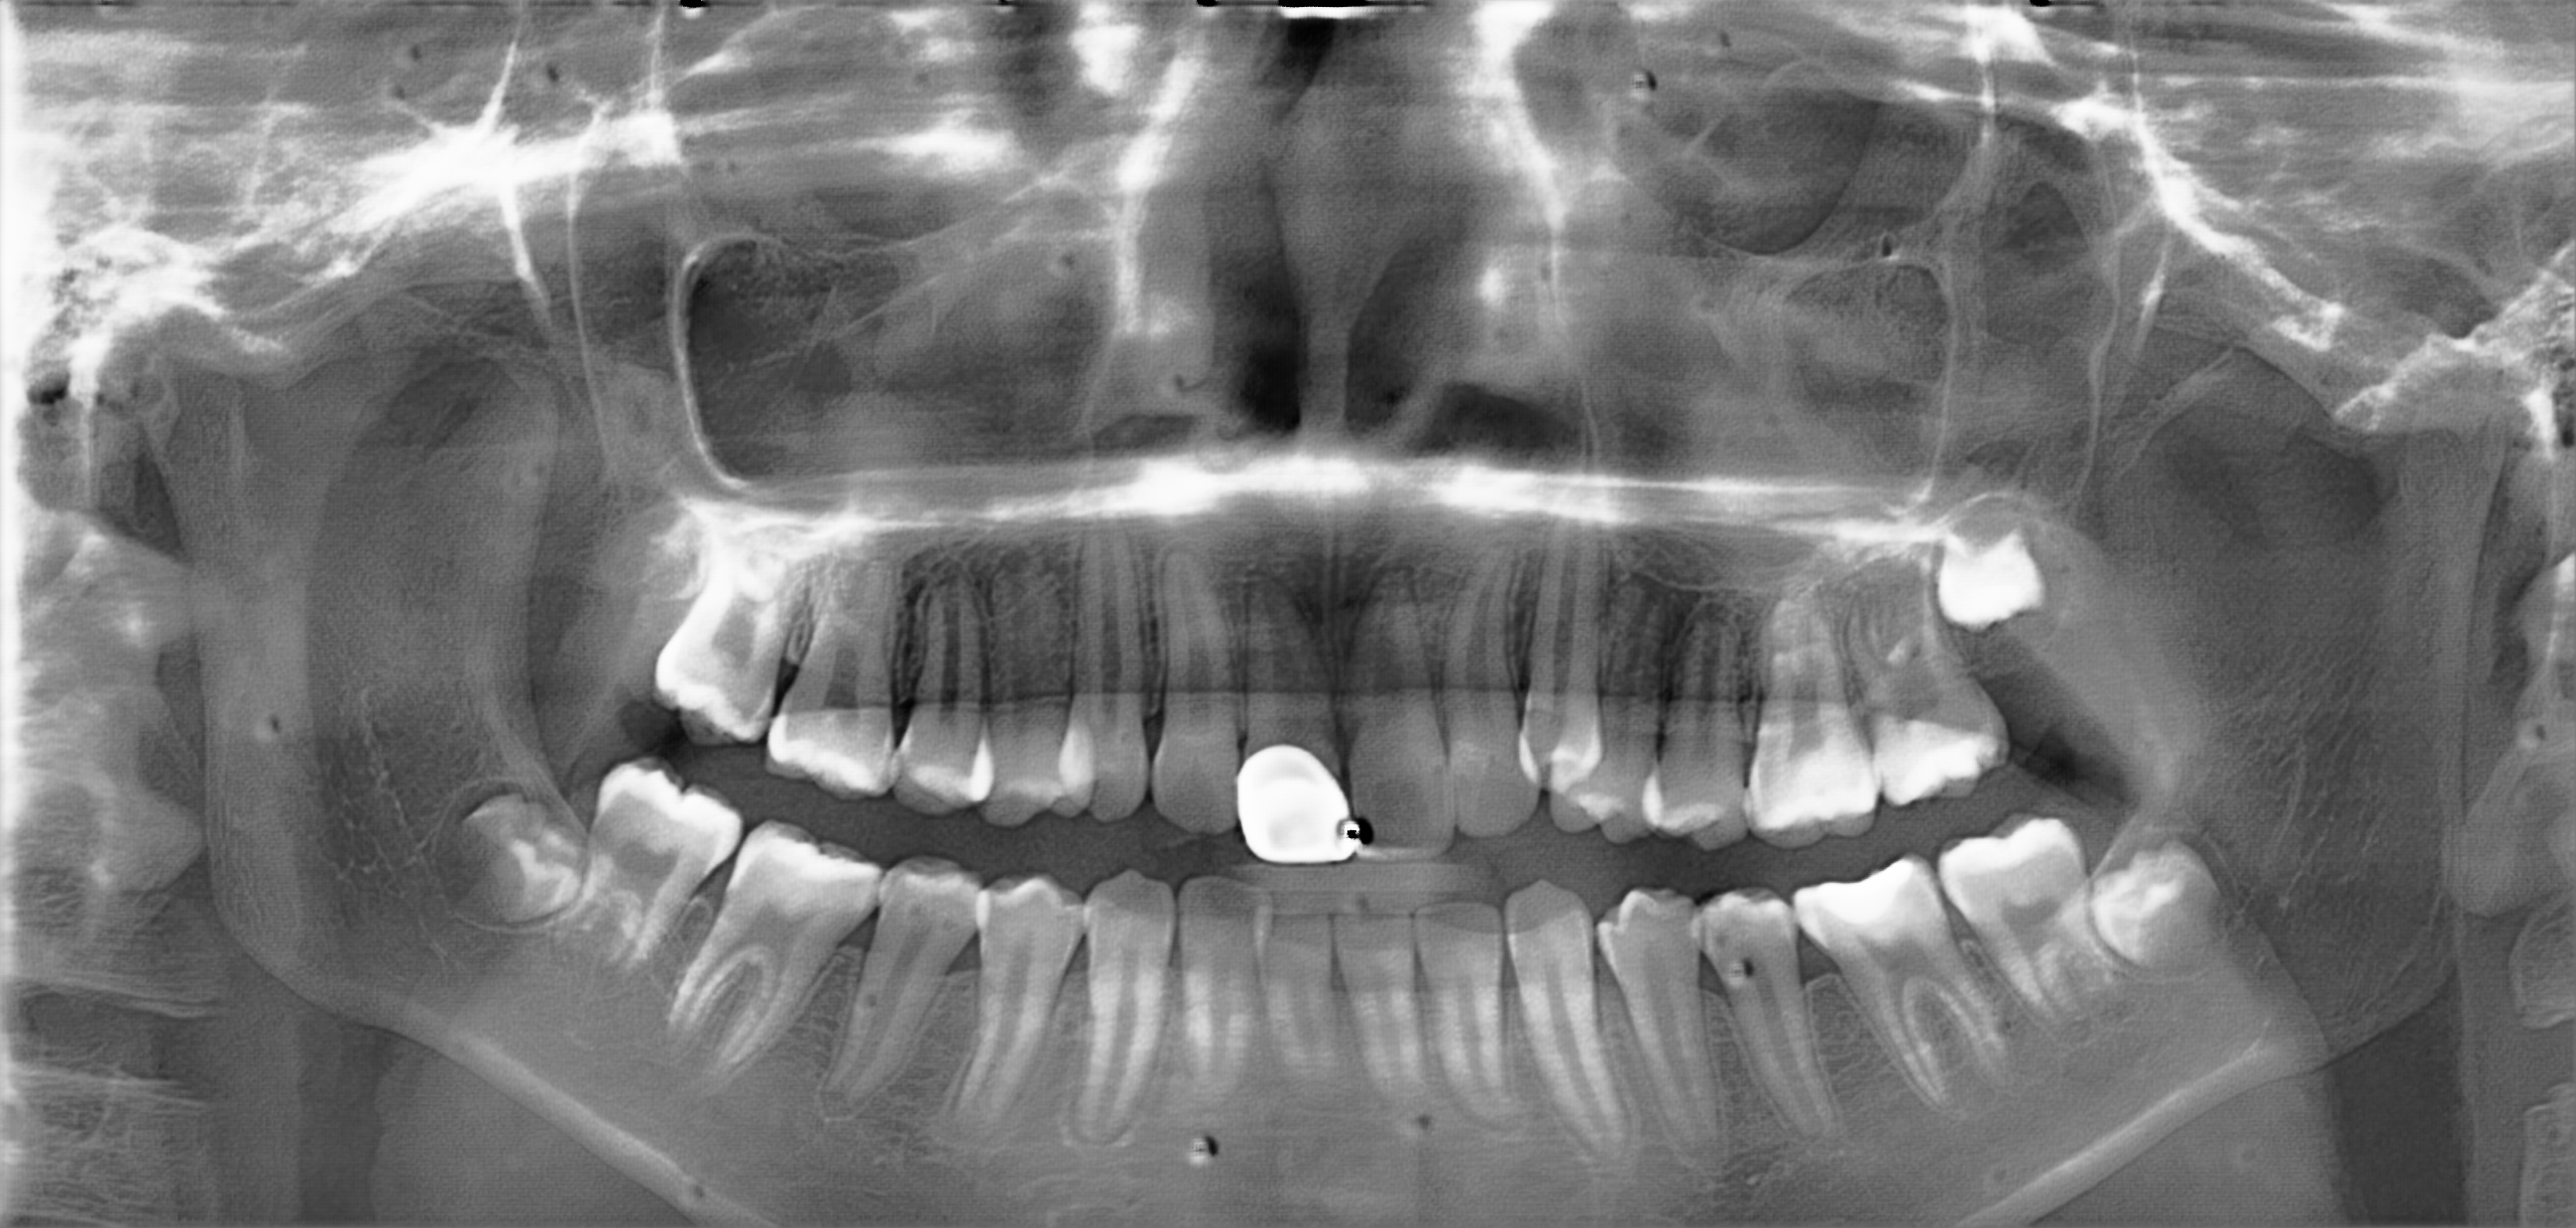

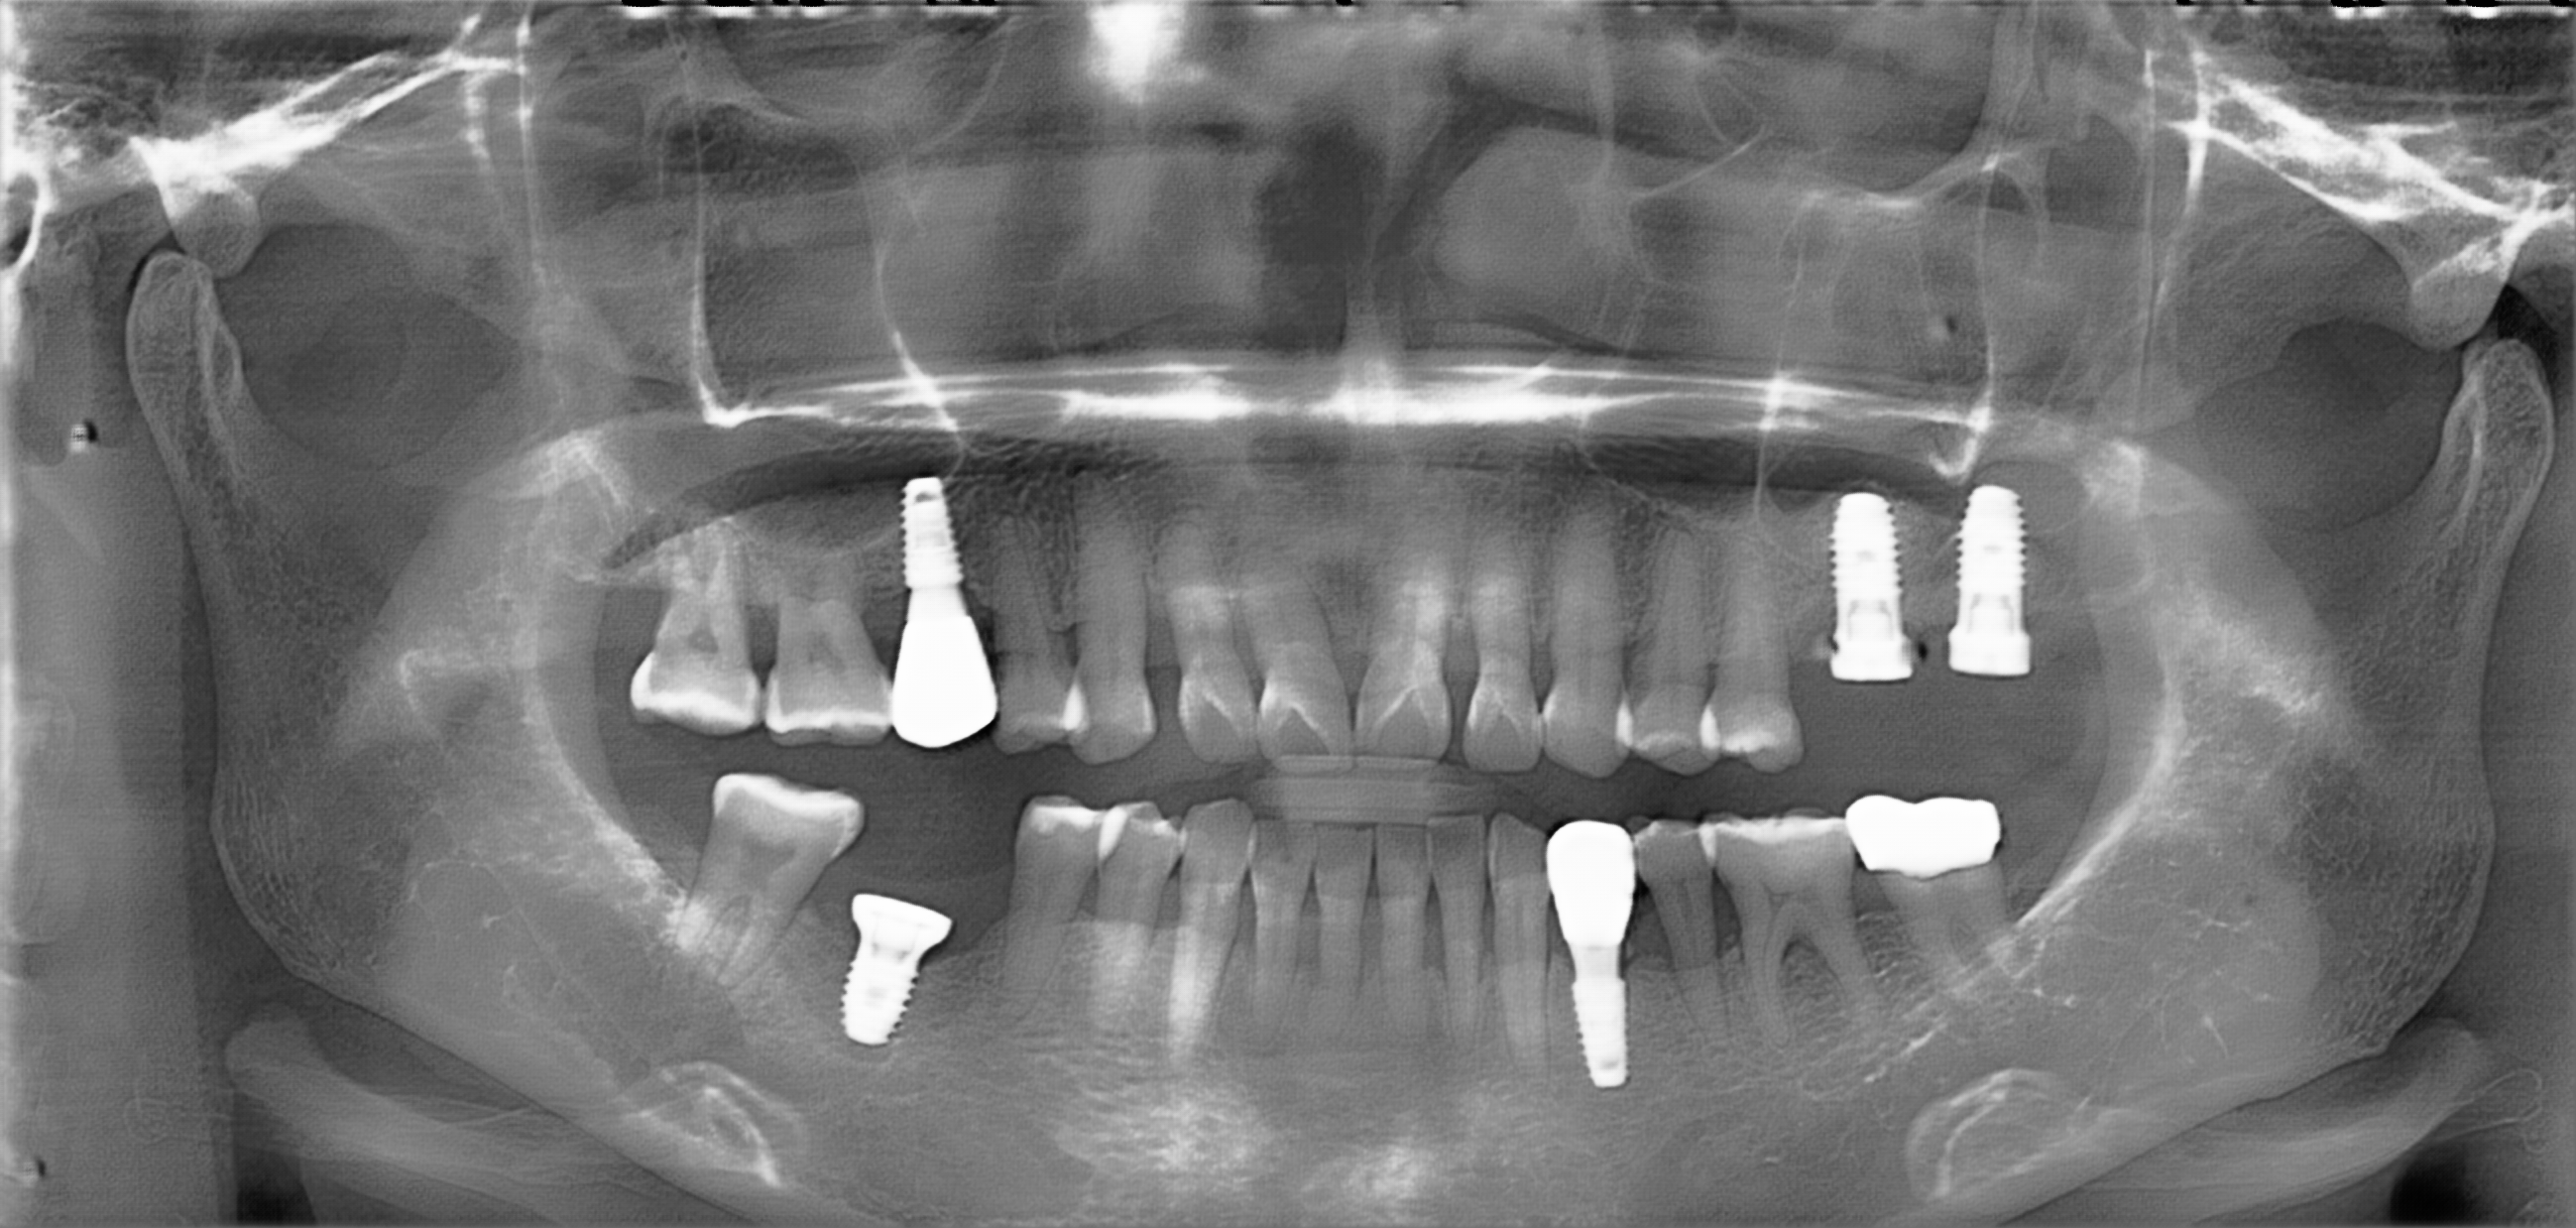

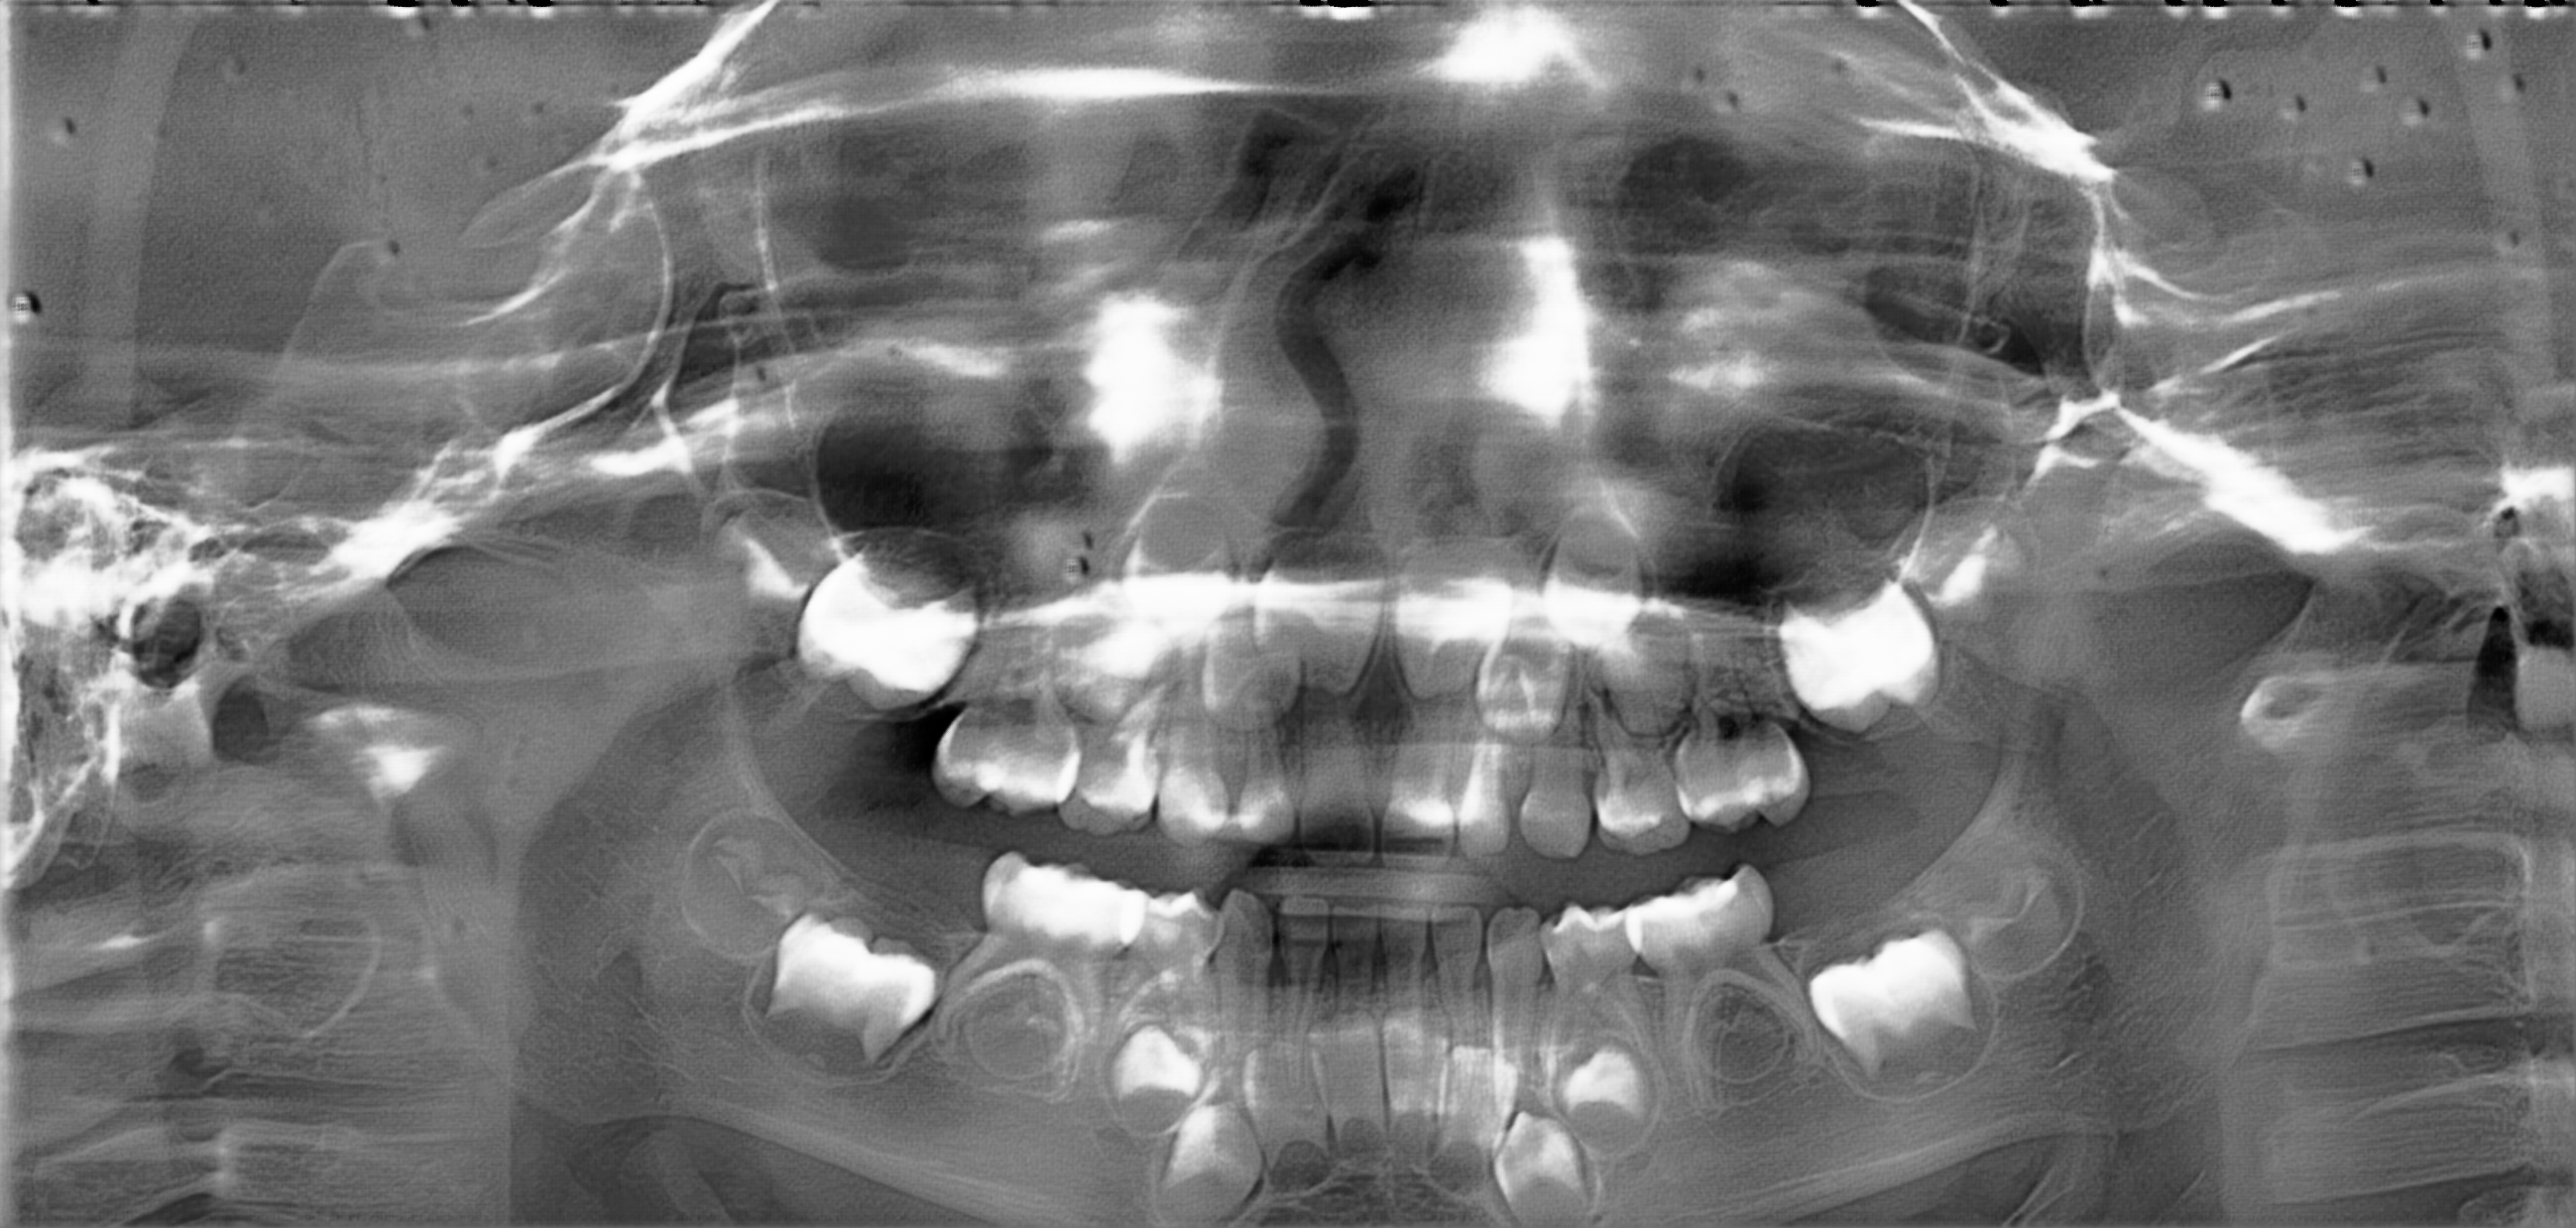

In [3]:
import numpy as np
from datasets.dataloader import *
from models.base_model import *
import torch
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eval_loader=get_eval_loader(root="./data/processed/V", batch_size=1, shuffle=False,gray=True)

model=NonResizing_GrayGenerator(n_res=6).to(device)
checkpoint=torch.load('./checkpoints/CycleGAN/NonResizig_Gray/checkpoint-epoch-30.ckpt')
model.load_state_dict(checkpoint['F_state_dict'])
torch_to_image = transforms.Compose([
        transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),  # [-1, 1] to [0, 1]
        transforms.ToPILImage()
    ])

i=0
for im in eval_loader:
    im=im.to(device)
    result=model(im).to(device)
    result=torch.cat([result,result,result],1)
    result=torch_to_image(result[0])
    display(result)
    if i==2:
        break
    i+=1